<a href="https://colab.research.google.com/github/salmabassem/codes/blob/main/TF_Binding_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlphaGenome on CT45A Locus

The goal of this tutorial notebook is to quickly get you started with using the model and making predictions.

```{tip}
Open this tutorial in Google colab for interactive viewing.
```

In [ ]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

## Imports

In [ ]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import pandas as pd

## Predict outputs for a DNA sequence

AlphaGenome is a model that makes predictions from DNA sequences. Let's load it up:




```{tip}
If using Google Colab, store your key in "Secrets" for persistent access across sessions (see [installation](https://www.alphagenomedocs.com/installation.html#google-colab)). Otherwise, `dna_client.create` can take the API key directly.
```

In [ ]:
dna_model = dna_client.create(colab_utils.get_api_key("ALPHA_GENOME_API_KEY"))

The model can make predictions for the following [output types](https://www.alphagenomedocs.com/exploring_model_metadata.html):

In [ ]:
[output.name for output in dna_client.OutputType]

['ATAC',
 'CAGE',
 'DNASE',
 'RNA_SEQ',
 'CHIP_HISTONE',
 'CHIP_TF',
 'SPLICE_SITES',
 'SPLICE_SITE_USAGE',
 'SPLICE_JUNCTIONS',
 'CONTACT_MAPS',
 'PROCAP']

In [ ]:
import os
from google.colab import userdata

# Retrieve the secret
api_key = userdata.get('ALPHA_GENOME_API_KEY')

# Set it as an environment variable (optional)
os.environ["ALPHA_GENOME_API_KEY"] = api_key
dna_model = dna_client.create(api_key)

# Add a print statement to confirm model creation
if dna_model:
    print("AlphaGenome model created successfully.")
else:
    print("Failed to create AlphaGenome model. Please check your API key.")

AlphaGenome model created successfully.


Predict TF Binding at CT45A1 Locus in K562 vs THP1 vs Normal Myeloid Progenitor
                                                                                                              

In [ ]:
import pandas as pd
from alphagenome.data import gene_annotation, transcript, genome
from alphagenome.visualization import plot_components

# Load gene annotation GTF (GENCODE v46)
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Filter to high-confidence protein-coding transcripts
gtf_transcript = gene_annotation.filter_transcript_support_level(
    gene_annotation.filter_protein_coding(gtf), ['1']
)

# Extract longest transcripts per gene
gtf_longest_transcript = gene_annotation.filter_to_longest_transcript(gtf_transcript)
longest_transcript_extractor = transcript.TranscriptExtractor(gtf_longest_transcript)

# Define CT45A1 interval and resize to 1MB window
interval = gene_annotation.get_gene_interval(gtf, gene_symbol='CT45A1').resize(131072)


ontology_terms = ['EFO:0002067',
                  'EFO:0002791',
                  'CL:0001059']

['XRCC4' 'YY1' 'POLR2G' 'BRF2' 'THAP1' 'POLR2AphosphoS5' 'MAX' 'SPI1'
 'SMC3' 'U2AF2' 'RBM17' 'POLR2AphosphoS2' 'RBFOX2' 'AGO1' 'RAD21' 'ZBTB7A'
 'SRSF9' 'CBX1' 'SIX5' 'FOSL1' 'TAF7' 'ZFP36' 'KDM4B' 'SAFB2' 'ZNF146'
 'SIN3A' 'ETS1' 'JUN' 'XRCC5' 'NEUROD1' 'HNRNPL' 'SAFB' 'ZKSCAN1' 'MYC'
 'GATA1' 'MAZ' 'FOXM1' 'CHD1' 'ZNF384' 'ARID3A']


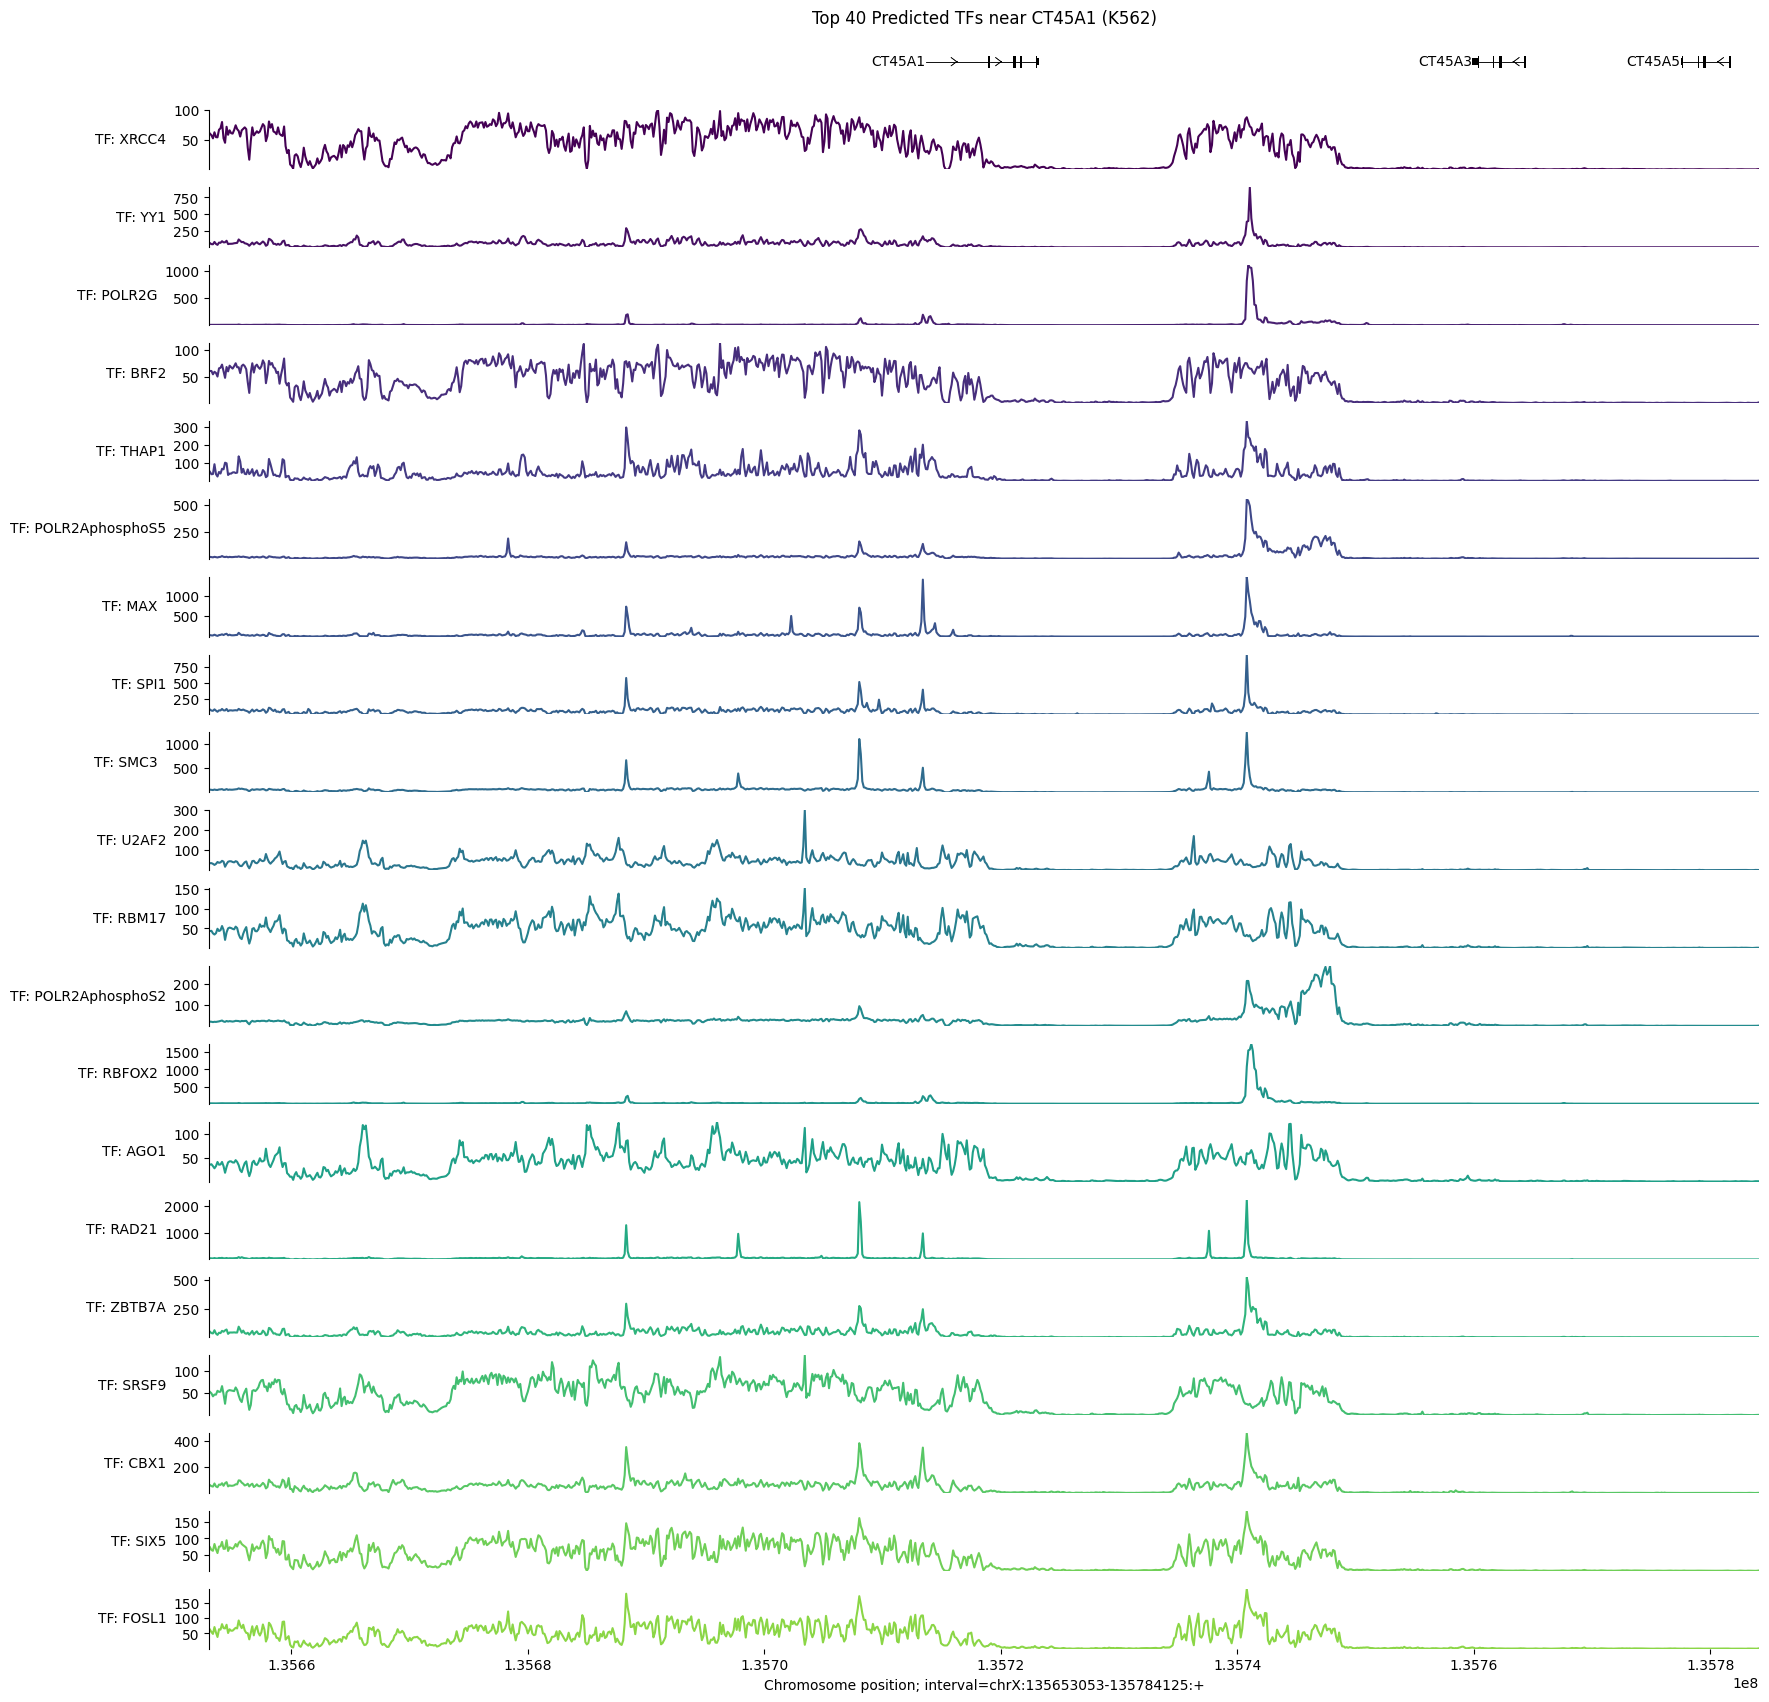

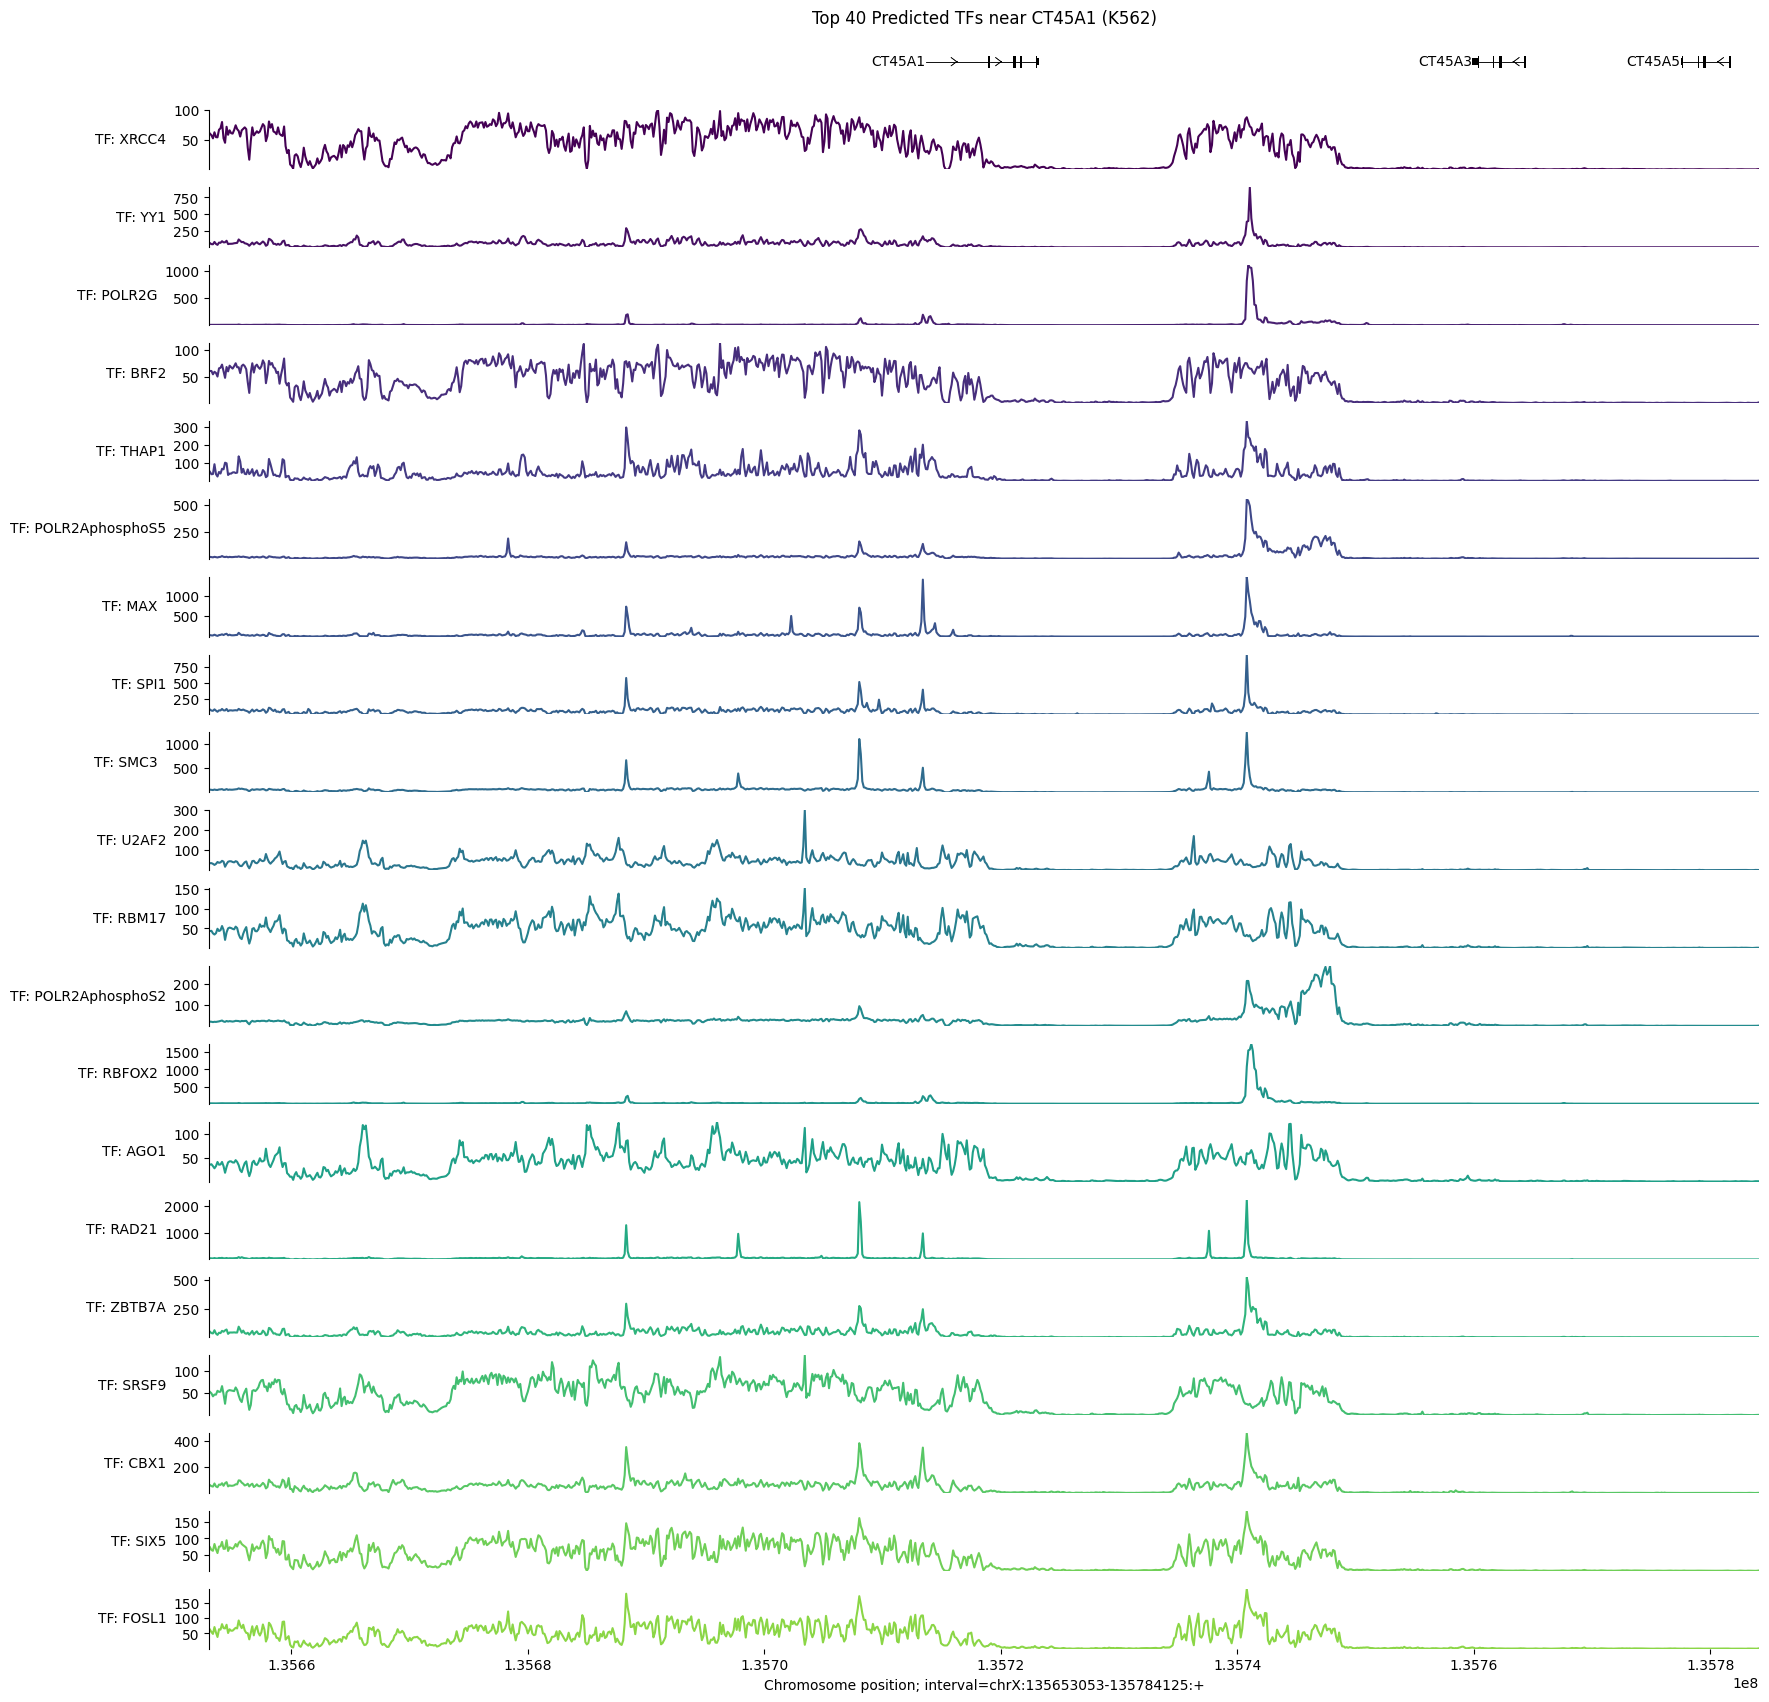

In [ ]:
# Set ontology term for myeloblast (AML-relevant context)
ontology_terms = ['EFO:0002067']

# Predict TF binding (CHIP_TF) near CT45A1
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs={dna_client.OutputType.CHIP_TF},
    ontology_terms=ontology_terms,
)

# Extract transcripts for visualization
longest_transcripts = longest_transcript_extractor.extract(interval)


chip_tf = output.chip_tf  # TrackData object
chip_tf_metadata = chip_tf.metadata  # Pandas DataFrame

top_tf_names = (
    chip_tf_metadata
    .sort_values('nonzero_mean', ascending=False)
    .head(40)['transcription_factor']
    .unique()
)
print(top_tf_names)
top_tf_names = (
    chip_tf_metadata
    .sort_values('nonzero_mean', ascending=False)
    .head(20)['name']
    .unique()
)

top_tf_mask = chip_tf_metadata['transcription_factor'].isin(top_tf_names)
filtered_metadata = chip_tf_metadata[top_tf_mask]

filtered_chip_tf = chip_tf.select_tracks_by_name(top_tf_names)

plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=filtered_chip_tf,
            ylabel_template='TF: {transcription_factor}',
        ),
    ],
    interval=interval,
    title='Top 40 Predicted TFs near CT45A1 (K562)',
)
plot



['POLR2AphosphoS2' 'SMARCB1' 'REST' 'RAD21' 'TAF1' 'CHD2' 'POLR2A' 'GABPA'
 'NR2C2' 'SUPT20H' 'NFYA' 'E2F4' 'CEBPB' 'TBP' 'MXI1' 'JUND' 'E2F1' 'BRF2'
 'NFYB' 'MAZ' 'PRDM1' 'GTF2F1' 'POLR3A' 'CTCF' 'USF2' 'JUN' 'ELK4' 'ELK1'
 'STAT3' 'MAX' 'BRCA1' 'RFX5' 'SMARCC1' 'NFE2L2' 'HCFC1' 'MAFK' 'MAFF'
 'SMC3' 'EP300' 'TCF7L2']


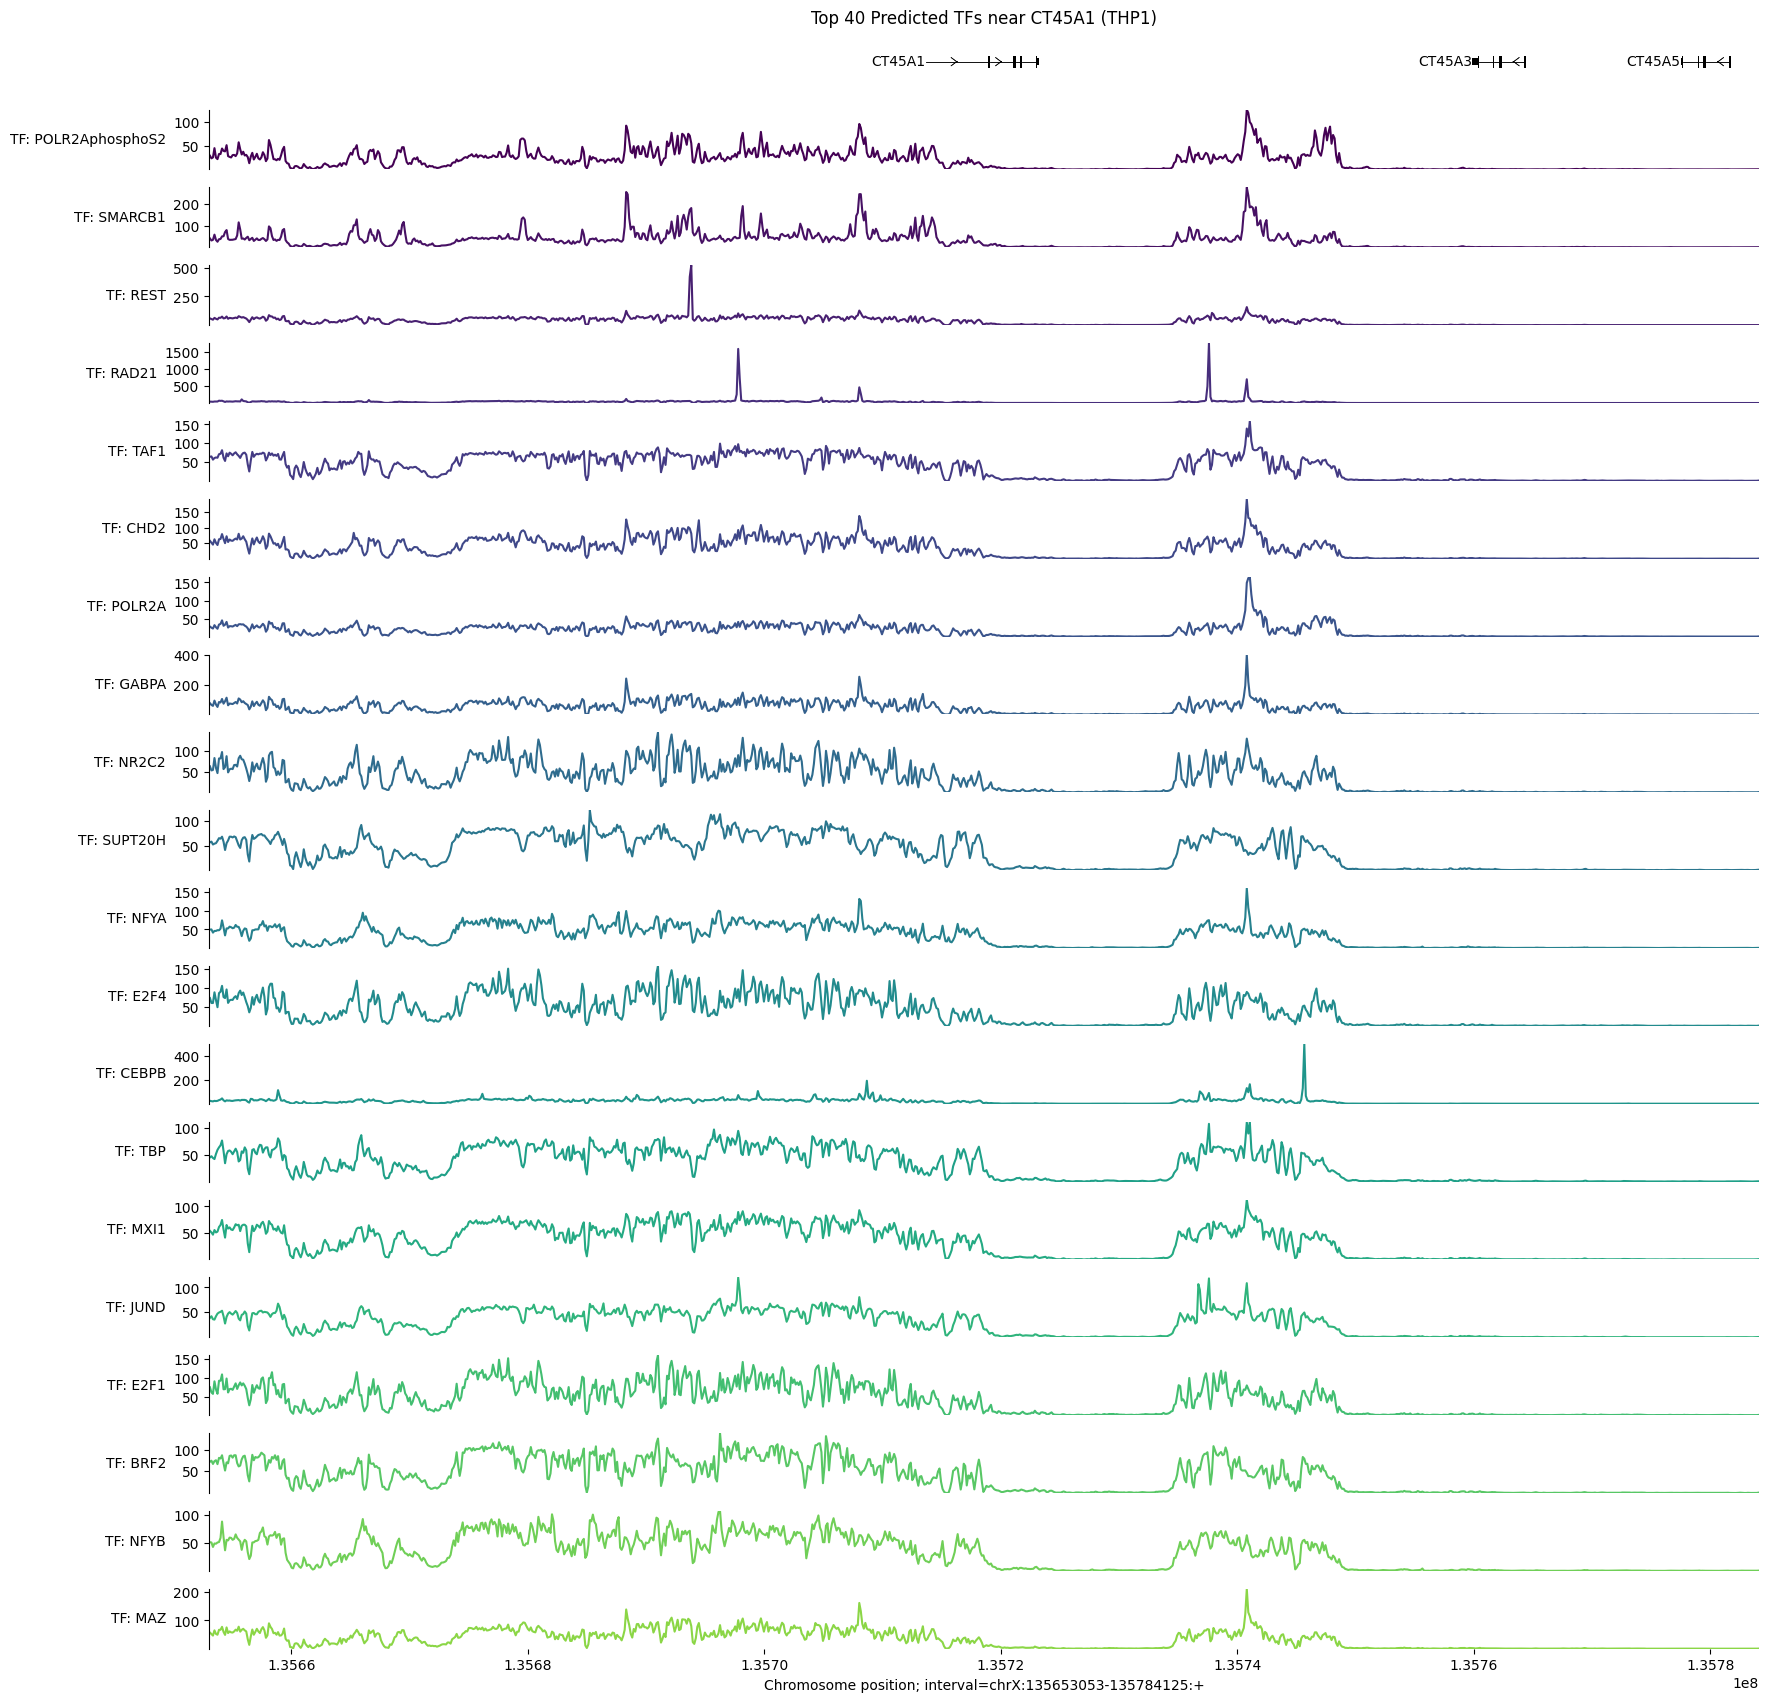

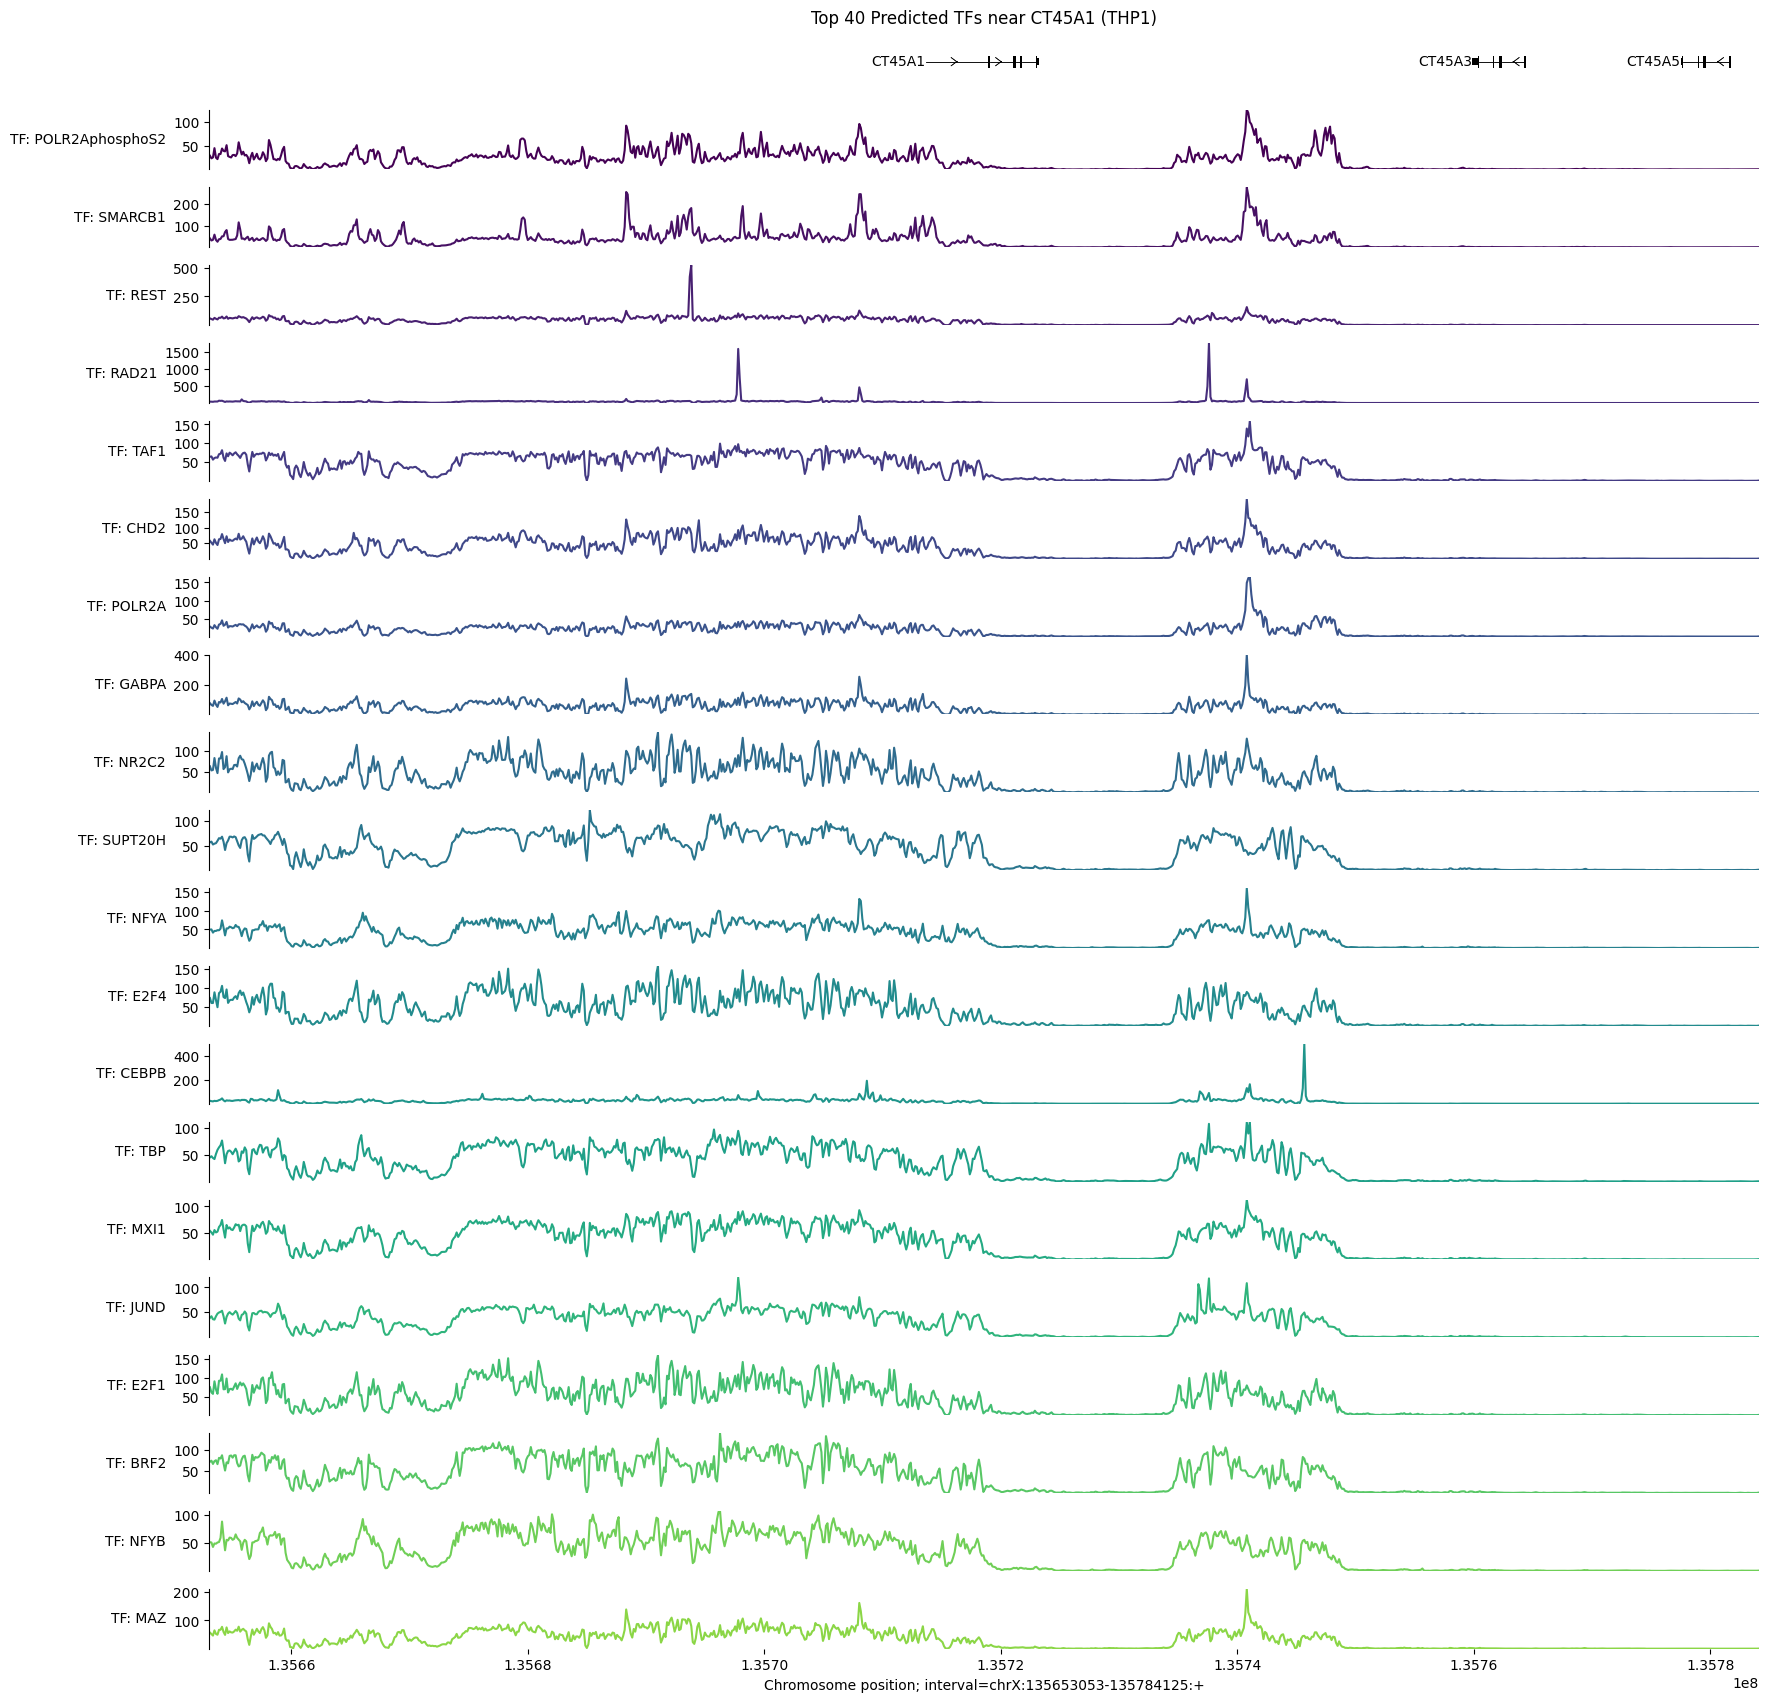

In [ ]:
# Set ontology term for myeloblast THP1)
ontology_terms = ['EFO:0002791']

# Predict TF binding (CHIP_TF) near CT45A1
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs={dna_client.OutputType.CHIP_TF},
    ontology_terms=ontology_terms,
)

# Extract transcripts for visualization
longest_transcripts = longest_transcript_extractor.extract(interval)


chip_tf = output.chip_tf  # TrackData object
chip_tf_metadata = chip_tf.metadata  # Pandas DataFrame

top_tf_names = (
    chip_tf_metadata
    .sort_values('nonzero_mean', ascending=False)
    .head(40)['transcription_factor']
    .unique()
)
print(top_tf_names)
top_tf_names = (
    chip_tf_metadata
    .sort_values('nonzero_mean', ascending=False)
    .head(20)['name']
    .unique()
)

top_tf_mask = chip_tf_metadata['transcription_factor'].isin(top_tf_names)
filtered_metadata = chip_tf_metadata[top_tf_mask]

filtered_chip_tf = chip_tf.select_tracks_by_name(top_tf_names)

plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=filtered_chip_tf,
            ylabel_template='TF: {transcription_factor}',
        ),
    ],
    interval=interval,
    title='Top 40 Predicted TFs near CT45A1 (THP1)',
)
plot



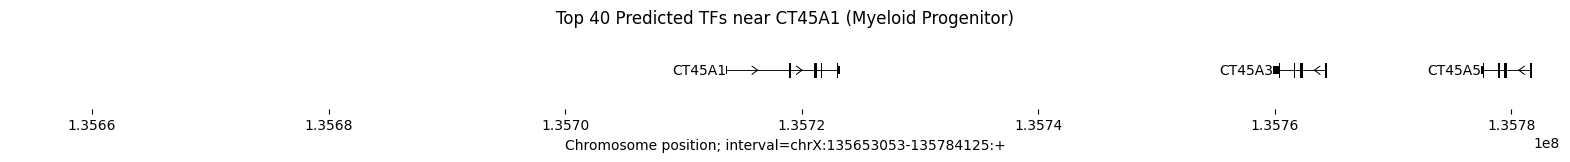

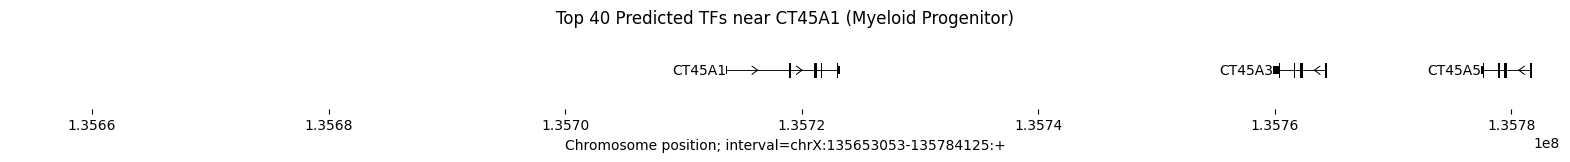

In [ ]:
# Set ontology term for myeloblast (AML-relevant context)
ontology_terms = ['CL:0001059']

# Predict TF binding (CHIP_TF) near CT45A1
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs={dna_client.OutputType.CHIP_TF},
    ontology_terms=ontology_terms,
)

# Extract transcripts for visualization
longest_transcripts = longest_transcript_extractor.extract(interval)


chip_tf = output.chip_tf  # TrackData object
chip_tf_metadata = chip_tf.metadata  # Pandas DataFrame

plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=chip_tf,
            ylabel_template='TF: {transcription_factor}',
        ),
    ],
    interval=interval,
    title='Top 40 Predicted TFs near CT45A1 (Myeloid Progenitor)',
)
plot

